In [88]:
# LS model with on-the-job search (decentralized and Planner's)

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, int64, float64
from interpolation import interp
from IPython.core.debugger import set_trace
from scipy.optimize import minimize
import copy
import pandas as pd
import os

class LSOnJob:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate at firm
    xi is probability of searching on-the-job
    eta is workers bargaining power with firm
    phi is effectiveness of matching function
    alpha is elasticity of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    gamma is steepness of marginal cost, 
    c_grid is level of entry cost
    """
    def __init__(self, B, b, delta, xi, eta, phi, alpha, y_min, y_max, y_grid_size, gamma, c_grid):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.c_grid = B, b, delta, eta, gamma, c_grid
        self.xi = xi
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size, self.y_min, self.y_max = y_grid_size, y_min, y_max    
        self.rm = (y_max - y_min) / y_grid_size
        
        self.phi, self.alpha = phi, alpha
        
# Set up neccesary functions
def lsoj_operator_factory(lsoj):
    
    r, b, delta, eta, gamma, c_grid = lsoj.r, lsoj.b, lsoj.delta, lsoj.eta, lsoj.gamma, lsoj.c_grid
    xi = lsoj.xi
    phi, alpha = lsoj.phi, lsoj.alpha
    xi_bar = xi * (1 - delta)
    
    y_grid, y_grid_size, rm = lsoj.y_grid, lsoj.y_grid_size, lsoj.rm
    
    @njit()
    def q(theta):
        return min(phi * theta**(-alpha), 1)
    
    @njit()
    def ell(theta):
        return min(phi * theta**(1 - alpha), 1)
    
    # Planner's problem also uses derivatives
    @njit()
    def q_p(theta):
        return (q(theta) < 1) * (-alpha * phi * theta**(-alpha - 1))
#         return (-alpha * phi * theta**(-alpha - 1))
    
    @njit()
    def ell_p(theta):
        return (ell(theta) < 1) * ((1 - alpha) * phi * theta**(-alpha))
#         return ((1 - alpha) * phi * theta**(-alpha))
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return c_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return c_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(cost_grid):
        return (np.maximum(cost_grid, 0) / (gamma * c_grid))**(1 / (gamma - 1))
    
    # Given v_grid, and n_grid find the distribution of workers
    # Including market tightness theta and distribution of vacancies f_grid
    @njit()
    def lsoj_worker_dist(v_grid, n_grid):
        
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        s = u + xi_bar * n
        
        # Calculate theta 
        theta = v / s
        
        # f is pdf of vacancies 
        F_grid = np.cumsum(v_grid * rm) / v
        f_grid = v_grid / v
        
        # G_grid is share of jobseekers at less productive firms
        G_grid = (u + xi_bar * np.cumsum(n_grid * rm)) / s
        
        # D_grid is probability the worker leaves for a better job
        D_grid = 1 - F_grid
        
        return theta, f_grid, G_grid, D_grid
    
    # Solve decentralized problem
    # Given v_grid, and n_grid find
    # Market tightness theta and Wages w
    @njit()
    def lsoj_make_grids(v_grid, n_grid):    
        
        # Get distribution of workers
        theta, f_grid, G_grid, D_grid = lsoj_worker_dist(v_grid, n_grid)
        
        # What is the value of search?        
        f_tot = c(v_grid) / G_grid * f_grid * rm
        i_cum_f = np.cumsum(f_tot[::-1])[::-1]
        Gamma_grid = ell(theta) / q(theta) * eta / (1 - eta) * i_cum_f
        Gamma_U = Gamma_grid[0]
        
        # Find wage
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - xi_bar * Gamma_grid)
        
        return theta, w_grid, Gamma_U, Gamma_grid, G_grid, D_grid
    
    # Given v_grid and n_grid find new values
    @njit()
    def lsoj_iterate(v_grid, n_grid):
        
        theta, w_grid, Gamma_U, Gamma_grid, G_grid, D_grid = lsoj_make_grids(v_grid, n_grid)
        
        # Value of firm
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + xi_bar * ell(theta) * D_grid)
        
        # Update vacancies
        v_grid_new = c_inv(J_hire)
        
        # Update positions
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
                       
        return v_grid_new, n_grid_new
    
    # Solve Planner's problem    
#     # Given v_grid, n_grid, and lam_grid find new values
#     @njit()
#     def lsoj_iterate_p(v_grid, n_grid, lam_grid):
        
#         # Get Distribution of workers (Planner's Problem more complicated, so want all parts)
#         # Define aggregate populations (make sure all exist)
#         n = max(np.sum(n_grid * rm), 1e-9)
#         u = max(1 - n, 1e-9)
#         v = max(np.sum(v_grid * rm), 1e-9)
#         s = u + xi_bar * n
        
#         # Calculate theta 
#         theta = v / s
        
#         # f is pdf of vacancies 
#         F_grid = np.cumsum(v_grid * rm) / v
#         # D_grid is probability the worker leaves for a better job
#         D_grid = 1 - F_grid
        
#         # G_grid is share of jobseekers at less productive firms
#         G_grid = (u + xi_bar * np.cumsum(n_grid * rm)) / s     
        
#         # Use lamda to find firm value of entry
#         # Three temp functions needed
#         temp_1 = lam_grid * (1 - D_grid) * n_grid * rm
#         temp_1_sum = np.cumsum(temp_1)
#         temp_2 = lam_grid * D_grid * n_grid * rm
#         temp_2_sum = np.cumsum(temp_2[::-1])[::-1]
#         temp = temp_1_sum - temp_2_sum
        
#         # Value of firms
#         J_hire = (
#             B * lam_grid * G_grid * q(theta)
#             + (q_p(theta) * np.sum(B * lam_grid * G_grid * v_grid * rm)
#                - ell_p(theta) * xi_bar * np.sum(B * lam_grid * D_grid * n_grid * rm)) / s
#             - xi_bar * B * ell(theta) * temp / v
#         )
        
        
# #         vac_sum = np.sum(lam_grid * G_grid * v_grid * rm)
# #         pos_sum = xi_bar * np.sum(lam_grid * D_grid * n_grid * rm)
        
# #         common_temp = q_p(theta) * vac_sum - ell_p(theta) * pos_sum
        
# #         vac_ext = B / s * (common_temp - xi_bar * ell(theta) * temp / theta)
        
# #         J_hire = (
# #             B * lam_grid * G_grid * q(theta) + vac_ext
# #         )
        
#         # Another attempt
# #         c_tot = np.sum(c(v_grid) * v_grid * rm)
        
# #         temp_a_1 = (1 - D_grid) * lam_grid * n_grid * rm
# #         temp_a_1_sum = np.cumsum(temp_1)
# #         temp_a_2 = D_grid * lam_grid * n_grid * rm
# #         temp_a_2_sum = np.cumsum(temp_2[::-1])[::-1]
# #         temp_a = temp_1_sum - temp_2_sum
# #         temp_a_sum = np.sum(temp_a * v_grid * rm) / v
        
# #         J_hire = (
# #             B * lam_grid * G_grid * q(theta)
# #             + c_tot / (s * theta) - q(theta) / theta * np.sum(B * lam_grid * G_grid * v_grid * rm) 
# #             - xi_bar * B * ell(theta) * (temp - temp_a_sum) / v
# #         )
        
#         # Update vacancies
#         v_grid_new = c_inv(J_hire)
        
#         # Update positions
#         n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
# #         n_grid_new = q(theta) * G_grid * v_grid / (delta + xi_bar * ell(theta) * D_grid)
        
#         # Update lambda
#         # Need three temp functions for one of integrals
#         temp_3 = lam_grid * (1 - (1 - xi_bar) * G_grid) * v_grid * rm
#         temp_3_sum = np.cumsum(temp_3)
#         temp_4 = lam_grid * (1 - xi_bar) * (1 - G_grid) * v_grid * rm
#         temp_4_sum = np.cumsum(temp_4[::-1])[::-1]
#         temp_b = temp_3_sum + temp_4_sum
        
#         lam_grid_new = (
#             (((1 + r) * (y_grid - b) + q(theta) * temp_b / s 
#               + (1 - xi_bar) * theta / s
#               * (q_p(theta) * np.sum(lam_grid * G_grid * v_grid * rm) 
#                  - ell_p(theta) * xi_bar * np.sum(lam_grid * D_grid * n_grid * rm)))) 
#             / (r + delta + xi_bar * ell(theta) * D_grid)
#         )
        
# #         pos_ext = ((1 - xi_bar) * theta * common_temp + q(theta) * temp_b) / s
        
# #         lam_grid_new = ((1 + r) * (y_grid - b) + pos_ext) / (r + delta + xi_bar * ell(theta) * D_grid)
        
#         # Another way to calculate this
# #         c_tot = np.sum(c(v_grid) * v_grid * rm)
        
# #         temp_1 = lam_grid * v_grid * rm
# #         temp_1_sum = np.cumsum(temp_1)
# #         temp_2 = lam_grid * (1 - xi_bar) * v_grid * rm
# #         temp_2_sum = np.cumsum(temp_2[::-1])[::-1]
# #         temp = temp_1_sum + temp_2_sum
        
# #         temp_a_1 = (1 - D_grid) * lam_grid * n_grid * rm
# #         temp_a_1_sum = np.cumsum(temp_1)
# #         temp_a_2 = D_grid * lam_grid * n_grid * rm
# #         temp_a_2_sum = np.cumsum(temp_2[::-1])[::-1]
# #         temp_a = temp_1_sum - temp_2_sum
# #         temp_a_sum = np.sum(temp_a * v_grid * rm) / v
        
# #         lam_grid_new = (
# #             (((1 + r) * (y_grid - b - (1 - xi_bar) * c_tot / s)) + q(theta) * temp / s 
# #              - (1 - xi_bar) * xi_bar * ell(theta) * temp_a_sum / s) 
# #             / (r + delta + xi_bar * ell(theta) * D_grid)
# #         )
                       
#         return v_grid_new, n_grid_new, lam_grid_new

    # Solve Planner's problem
    # Given v_grid, n_grid, and lam_grid find
    # market tightness theta
    # position distribution G and vacancy distribution D
    # vacancy and position externalities
    @njit()
    def lsoj_make_grids_p(v_grid, n_grid, lam_grid):
    
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        s = u + xi_bar * n
        
        # Calculate theta 
        theta = v / s
        
        # f is pdf of vacancies 
        F_grid = np.cumsum(v_grid * rm) / v
        # D_grid is probability the worker leaves for a better job
        D_grid = 1 - F_grid
        
        # G_grid is share of jobseekers at less productive firms
        G_grid = (u + xi_bar * np.cumsum(n_grid * rm)) / s     
        
        # Use lamda to find vacancy externality
        # Three temp functions needed
        temp_1 = lam_grid * (1 - D_grid) * n_grid * rm
        temp_1_sum = np.cumsum(temp_1)
        temp_2 = lam_grid * D_grid * n_grid * rm
        temp_2_sum = np.cumsum(temp_2[::-1])[::-1]
        temp = xi_bar * ell(theta) * (temp_1_sum - temp_2_sum) / theta
        
        vac_sum = np.sum(lam_grid * G_grid * v_grid * rm)
        pos_sum = xi_bar * np.sum(lam_grid * D_grid * n_grid * rm)
        
        common_temp = q_p(theta) * vac_sum - ell_p(theta) * pos_sum
        
        vac_ext = B / s * (common_temp - temp)
        
        # Find position externality
        # Need three temp functions for one of integrals
        temp_3 = lam_grid * (1 - (1 - xi_bar) * G_grid) * v_grid * rm
        temp_3_sum = np.cumsum(temp_3)
        temp_4 = lam_grid * (1 - xi_bar) * (1 - G_grid) * v_grid * rm
        temp_4_sum = np.cumsum(temp_4[::-1])[::-1]
        temp_b = q(theta) * (temp_3_sum + temp_4_sum)
        
        pos_ext = ((1 - xi_bar) * theta * common_temp - temp_b) / s
        
#         print(theta, vac_ext, pos_ext)
        
        return theta, G_grid, D_grid, vac_ext, pos_ext

    # Another attempt using entry instead of q_p and ell_p
    # Solve Planner's problem
    # Given v_grid, n_grid, and lam_grid find
    # market tightness theta
    # position distribution G and vacancy distribution D
    # vacancy and position externalities
    @njit()
    def lsoj_make_grids_2_p(v_grid, n_grid, lam_grid):
    
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        s = u + xi_bar * n
        
        # Calculate theta 
        theta = v / s
        
        # f is pdf of vacancies 
        F_grid = np.cumsum(v_grid * rm) / v
        f_grid = v_grid / v
        # D_grid is probability the worker leaves for a better job
        D_grid = 1 - F_grid
        
        # G_grid is share of jobseekers at less productive firms
        G_grid = (u + xi_bar * np.cumsum(n_grid * rm)) / s  
        
        # Find total marginal cost of entry
        c_av = np.sum(c(v_grid) * f_grid * rm)
        
        # This term in both vac_ext and pos_ext    
        temp_1 = lam_grid * (1 - D_grid) * n_grid * rm
        temp_1_sum = np.cumsum(temp_1)
        temp_2 = lam_grid * D_grid * n_grid * rm
        temp_2_sum = np.cumsum(temp_2[::-1])[::-1]
        
        temp_vac = xi_bar * ell(theta) * (temp_1_sum - temp_2_sum) / v
        temp_both = (1 + r) * c_av + np.sum(temp_vac * f_grid * rm)
        
        # Find vacancy externality
        vac_ext = B * (temp_both - q(theta) * np.sum(lam_grid * G_grid * f_grid * rm) - temp_vac)
        
        temp_3 = lam_grid * f_grid * rm
        temp_3_sum = np.cumsum(temp_3)
        temp_4 = lam_grid * (1 - xi_bar) * f_grid * rm
        temp_4_sum = np.cumsum(temp_4[::-1])[::-1]
        temp_pos = q(theta) * (temp_3_sum + temp_4_sum)
        
        # Find position externality        
        pos_ext = ((1 - xi_bar) * temp_both - temp_pos) * theta
        
#         print(theta, vac_ext, pos_ext)
        
        return theta, G_grid, D_grid, vac_ext, pos_ext
        
    # Given v_grid, n_grid, and lam_grid find new values
    @njit()
    def lsoj_iterate_p(v_grid, n_grid, lam_grid):
        
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        s = u + xi_bar * n
        
        # Calculate theta 
        theta = v / s
        
        if q(theta) < 1:
            theta, G_grid, D_grid, vac_ext, pos_ext = lsoj_make_grids_p(v_grid, n_grid, lam_grid)
        else:
            theta, G_grid, D_grid, vac_ext, pos_ext = lsoj_make_grids_2_p(v_grid, n_grid, lam_grid)
            
        # Value of firms
        J_hire = B * lam_grid * G_grid * q(theta) + vac_ext
        
        # Update vacancies
        v_grid_new = c_inv(J_hire)
        
        # Update positions
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
                         
        # Update lambda
        lam_grid_new = ((1 + r) * (y_grid - b) + pos_ext) / (r + delta + xi_bar * ell(theta) * D_grid)
                       
        return v_grid_new, n_grid_new, lam_grid_new
    
    return (lsoj_iterate, lsoj_make_grids, lsoj_iterate_p, lsoj_make_grids_p, lsoj_make_grids_2_p,
            C, c, c_inv, q, ell, q_p, ell_p
)
# Solve decentralized model
def lsoj_solve_model(lsoj, guess, tol, max_iter, slow, verbose=False, print_skip=1e4):
    
    lsoj_iterate, _, _, _, _, _, _, _, _, _, _, _ = lsoj_operator_factory(lsoj)
    
    v_grid, n_grid = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1    

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new = lsoj_iterate(v_grid, n_grid)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err = max(err_v, err_n)

        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
        
        i += 1
    
    if i < max_iter:
        print(f'Converged in {i} iterations')
    if i == max_iter:
        print(f'Failed to Converge.')

    return v_grid_new, n_grid_new

# Solve Planner's model
def lsoj_solve_model_p(lsoj, guess, tol, max_iter, slow, verbose=False, print_skip=1e4):
    
    _, _, lsoj_iterate_p, lsoj_make_grids_p, lsoj_make_grids_2_p, _, _, _, _, _, _, _ = lsoj_operator_factory(lsoj)
    
    v_grid, n_grid, lam_grid = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1    
    
    rm = lsoj.rm

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new, lam_grid_new = lsoj_iterate_p(v_grid, n_grid, lam_grid)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err = max(err_v, err_n)

        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        lam_grid = slow * lam_grid_new + (1 - slow) * lam_grid
        
        if np.sum(v_grid_new) == 0:
            print(f"No entry for iteration {i}")
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
            theta, G_grid, D_grid, vac_ext, pos_ext = lsoj_make_grids_2_p(v_grid_new, n_grid_new, lam_grid_new)
            print(f"theta is {theta}", lam_grid_new, vac_ext, pos_ext)
            
        i += 1
    
    if i < max_iter:
        print(f'Converged in {i} iterations')
    if i == max_iter:
        print(f'Failed to Converge.')

    return v_grid_new, n_grid_new, lam_grid_new

# Plot decentralized
def lsoj_graph_results(lsoj, v_grid, n_grid, 
                        save=False, height=7, f=None, folder=None, file=None):

    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from lsoj
    lsoj_iterate, lsoj_make_grids, _, _, _, C, c, c_inv, q, ell, q_p, ell_p = lsoj_operator_factory(lsoj)
    
    theta, w_grid, Gamma_U, Gamma_grid, G_grid, D_grid = lsoj_make_grids(v_grid, n_grid)
    
    r, delta, xi = lsoj.r, lsoj.delta, lsoj.xi
    c_grid = lsoj.c_grid
    rm = lsoj.rm
    y_grid = lsoj.y_grid
    y_grid_size = lsoj.y_grid_size
    xi_bar = xi * (1 - delta)
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, lw=2, alpha=0.75)
    ax.plot(y_grid, y_grid, lw=2, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Wage $w$")
#     ax.legend(loc="upper left")

    if save:
        fig.savefig(folder + file + 'LS OJS Wages.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firm vacancies vs wages
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, v_grid * rm, lw=2, alpha=0.75)
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
#     ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'LS OJS Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, n_grid * rm, lw=2, alpha=0.75)
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
#     ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'LS OJS Positions.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    J_hire = (q(theta) * G_grid * (y_grid - w_grid) 
              / (r + delta + xi_bar * ell(theta) * D_grid))
    mc = c(v_grid)   
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, lw=2, alpha=0.75, label="Firm Marginal Value")
    ax.plot(y_grid, mc, lw=2, alpha=0.75, label="Firm Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'LS OJS M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid > 0], J_hire_diff[v_grid > 0], lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    
    if save:
        fig.savefig(folder + file + 'LS OJS M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot various distribributions for the firm
    v = np.sum(v_grid * rm)
    F_grid = np.minimum(np.cumsum(v_grid * rm) / v, 1)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, F_grid, lw=2, alpha=0.75, label=r"$F$")  
    ax.plot(y_grid, G_grid, lw=2, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid, lw=2, alpha=0.75, label=r"$D$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "LS OJS Firm Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Graph value of search by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, Gamma_grid, lw=2, alpha=0.75)
    ax.set(xlabel="Wage $w$", ylabel="Value of Serach")
    
    if save:
        fig.savefig(folder + file + 'LS OJS Value of Search.pdf')
    else:
        plt.show()
        
    plt.close()
        
# Create a function to print some facts that are useful for decentralized
def lsoj_list_facts(lsoj, v_grid, n_grid):
    
    lsoj_iterate, lsoj_make_grids, _, _, _, C, c, c_inv, q, ell, q_p, ell_p = lsoj_operator_factory(lsoj)
    
    theta, w_grid, Gamma_U, Gamma_grid, G_grid, D_grid = lsoj_make_grids(v_grid, n_grid)
    
    r, delta = lsoj.r, lsoj.delta
    gamma, c_grid, eta, xi = lsoj.gamma, lsoj.c_grid, lsoj.eta, lsoj.xi
    rm = lsoj.rm
    y_grid = lsoj.y_grid
    xi_bar = xi * (1 - delta)
    
    u = 1 - np.sum(n_grid * rm)
    u_lom = delta / (delta + ell(theta))
    v = np.sum(v_grid * rm)
    ue = ell(theta)
    ee = np.sum(n_grid * xi_bar * ell(theta) * D_grid * rm) / np.sum(n_grid * rm)
    
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {v:.4f}. Theta is {theta:.4f}")
    print(f"UE rate is {ue:.4f}; ee rate is {ee:.4f}")
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss = v_grid * q(theta) * G_grid / (delta + xi_bar * ell(theta) * D_grid)
    err = max(np.abs(n_ss - n_grid))
    err_at = np.argmax(np.abs(n_ss - n_grid))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Firms largest error = {err:.6f} at position {err_at} \n"
    ) 
    
# Plot Planner's vs Decentralized
def lsoj_graph_results_p(lsoj, v_grid, n_grid, v_grid_p, n_grid_p, lam_grid_p,
                        save=False, height=7, f=None, folder=None, file=None):

    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from lsoj
    lsoj_iterate, lsoj_make_grids, _, _, lsoj_make_grids_p,  C, c, c_inv, q, ell, q_p, ell_p = lsoj_operator_factory(lsoj)
    
    # Find Decentralized vs Planner's choices
    theta, w_grid, Gamma_U, Gamma_grid, G_grid, D_grid = lsoj_make_grids(v_grid, n_grid)
    theta_p, G_grid_p, D_grid_p, vac_ext, pos_ext = lsoj_make_grids_p(v_grid_p, n_grid_p, lam_grid_p)
    
    r, delta, xi = lsoj.r, lsoj.delta, lsoj.xi
    c_grid = lsoj.c_grid
    rm = lsoj.rm
    y_grid = lsoj.y_grid
    y_grid_size = lsoj.y_grid_size
    xi_bar = xi * (1 - delta)
        
    # Graph firm vacancies vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid * rm, lw=2, alpha=0.75, label="Dencentralized")
    ax.plot(y_grid, v_grid_p * rm, lw=2, alpha=0.75, label="Planner's")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'LS OJS DvP Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * rm, lw=2, alpha=0.75, label="Dencentralized")
    ax.plot(y_grid, n_grid_p * rm, lw=2, alpha=0.75, label="Planner's")
    ax.set(xlabel="Productivity $y$", ylabel="Positions $n$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'LS OJS DvP Positions.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    J_hire = (q(theta) * G_grid * (y_grid - w_grid) 
              / (r + delta + xi_bar * ell(theta) * D_grid))
    mc = c(v_grid)
    
    J_p = B * lam_grid_p * G_grid_p * q(theta_p) + vac_ext
    mc_p = c(v_grid_p)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, lw=2, alpha=0.75, label="D Firm Marginal Value")
    ax.plot(y_grid, mc, lw=2, alpha=0.75, label="D Firm Marginal Cost")
    ax.plot(y_grid, J_p, lw=2, alpha=0.75, label="P Firm Marginal Value")
    ax.plot(y_grid, mc_p, lw=2, alpha=0.75, label="P Firm Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'LS OJS DvP M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    J_p_diff = J_p - mc_p
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid > 0], J_hire_diff[v_grid > 0], lw=2, alpha=0.75, label="Decentralized")
    ax.plot(y_grid[v_grid_p > 0], J_p_diff[v_grid_p > 0], lw=2, alpha=0.75, label="Planner's")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'LS OJS DvP M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot various distribributions for the firm
    v = np.sum(v_grid * rm)
    v_p = np.sum(v_grid_p * rm)
    F_grid = np.minimum(np.cumsum(v_grid * rm) / v, 1)
    F_grid_p = np.minimum(np.cumsum(v_grid_p * rm) / v_p, 1)
    
    fig, ax = plt.subplots(figsize=(width, height))
#     ax.plot(y_grid, F_grid, lw=2, alpha=0.75, label=r"$F$")  
    ax.plot(y_grid, G_grid, lw=2, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid, lw=2, alpha=0.75, label=r"$D$")  
#     ax.plot(y_grid, F_grid_p, lw=2, alpha=0.75, label=r"$F^P$")  
    ax.plot(y_grid, G_grid_p, lw=2, alpha=0.75, label=r"$G^P$") 
    ax.plot(y_grid, D_grid_p, lw=2, alpha=0.75, label=r"$D^P$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "LS OJS DvP Firm Distributions.pdf")
    else:
        plt.show()
        
    plt.close()

Error at iter 0 is 0.0005
Error at iter 10000 is 0.0000
Error at iter 20000 is 0.0000
Converged in 28264 iterations
Unemployment is 12.68. According to LoM, should be 12.71
Workers match with probability 2.69. Firms/Outsourcers match with probability 44.70
Total vacancies searching for workers are 0.0188. Theta is 0.0602
UE rate is 0.0269; ee rate is 0.0020
Checking if vacancies + LoM imply right positions:
 Firms largest error = 0.000002 at position 773 



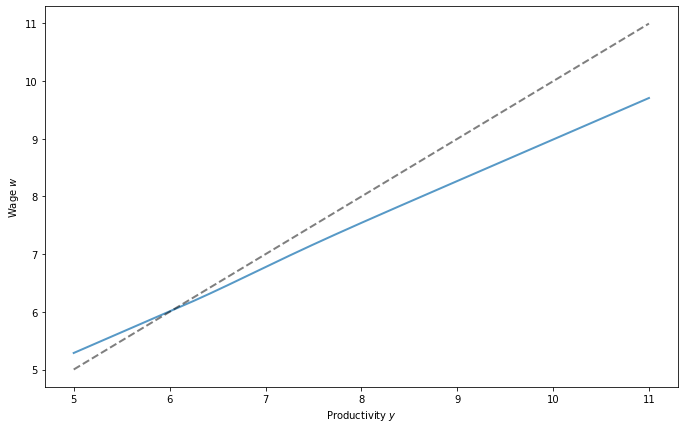

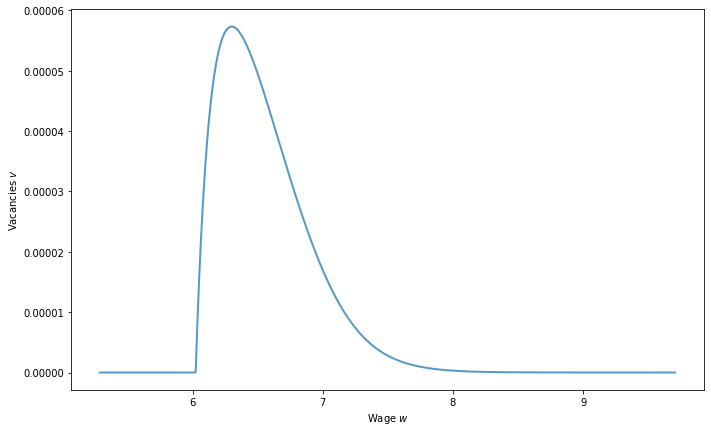

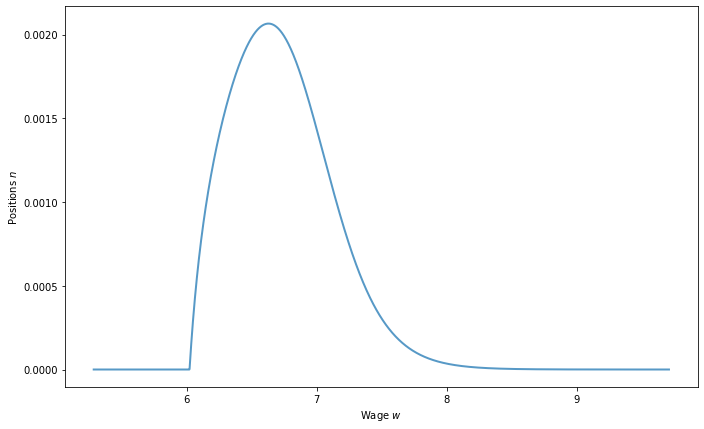

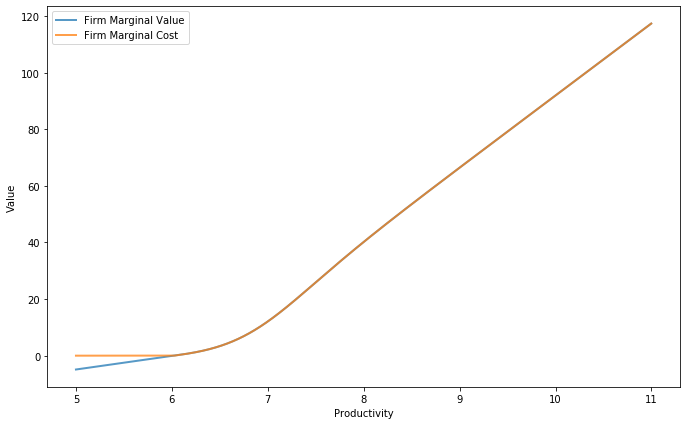

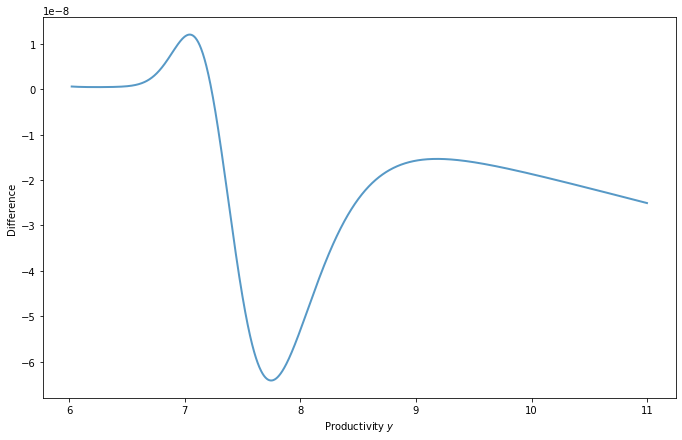

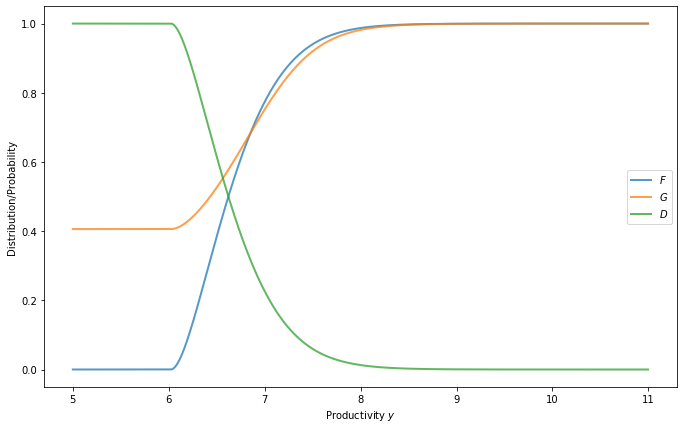

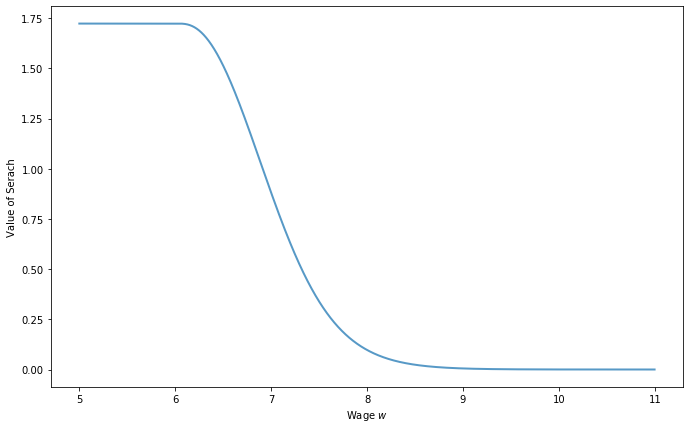

In [86]:
r = 0.0010010010010008674
B = 1 / (1 + r)
delta = 0.003914869459698093 
alpha = .72
# alpha = 0.5
phi = 0.059072385300564884 
eta = alpha
# eta = .5
y_min = 5
y_max = 11
b = 4.665923509864012 
y_grid_size = 2000
gamma = 2
xi = 0.21337305834104697 
# xi = 0
xi_bar = (1 - delta) * xi

y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
c_grid = np.exp(-19.994892596180378  + 3.7699826645606143 * y_grid)

tol = 1e-8
max_iter = 5e4
# max_iter = 1e5
slow = 1e-1
# slow = 5e-2
ps = 1e4
verbose = True

lsoj = LSOnJob(B, b, delta, xi, eta, phi, alpha, y_min, y_max, y_grid_size, gamma, c_grid)

# Record initial guesses
v_grid = np.ones(y_grid_size) / y_grid_size
n_grid = np.ones(y_grid_size) / y_grid_size * 0.1

guess = v_grid, n_grid

v_grid, n_grid = lsoj_solve_model(lsoj, guess, tol=tol, max_iter=max_iter, slow=slow, verbose=verbose, print_skip=ps)

lsoj_list_facts(lsoj, v_grid, n_grid)
lsoj_graph_results(lsoj, v_grid, n_grid)

No entry for iteration 0
Error at iter 0 is 0.0191
theta is 3.159891689525411e-09 [  31.4562699    31.73874656   32.02122322 ... 1287.9525371  1288.56342306
 1289.17430895] [1.63555367e+07 1.63555367e+07 1.63555367e+07 ... 1.95014075e+00
 1.29346412e+00 6.43439530e-01] [0. 0. 0. ... 0. 0. 0.]
Error at iter 10000 is 0.0001
theta is 0.017637511126386413 [-132.77389114 -132.43908106 -132.10427098 ...  850.35024201  850.96112729
  851.57201256] [ -41.1013647   -41.1013647   -41.1013647  ... -142.51382078 -142.51389072
 -142.51395999] [-1.52530575 -1.52530575 -1.52530575 ... -2.15121144 -2.15121169
 -2.15121193]
Error at iter 20000 is 0.0000
theta is 0.017699127365047883 [-132.8546454  -132.51998421 -132.18532302 ...  849.92957849  850.54046364
  851.15134877] [ -40.82051495  -40.82051495  -40.82051495 ... -142.21697971 -142.21705076
 -142.21712113] [-1.52655063 -1.52655063 -1.52655063 ... -2.15326366 -2.1532639
 -2.15326415]
Converged in 25923 iterations
Unemployment is 18.51. According to

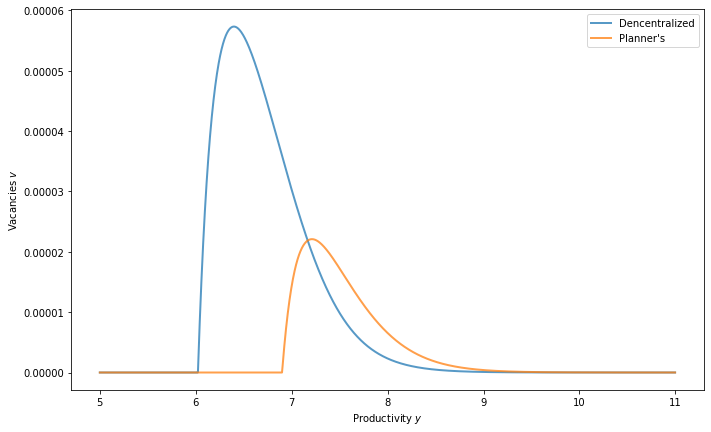

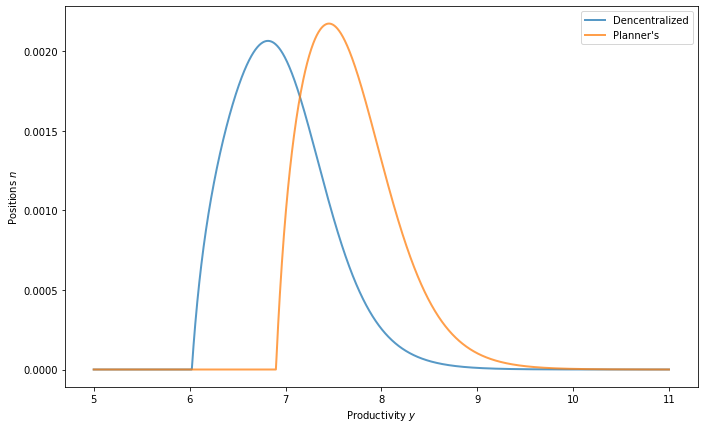

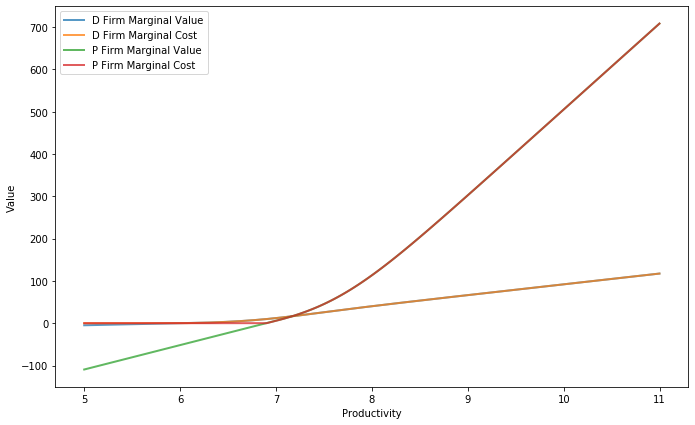

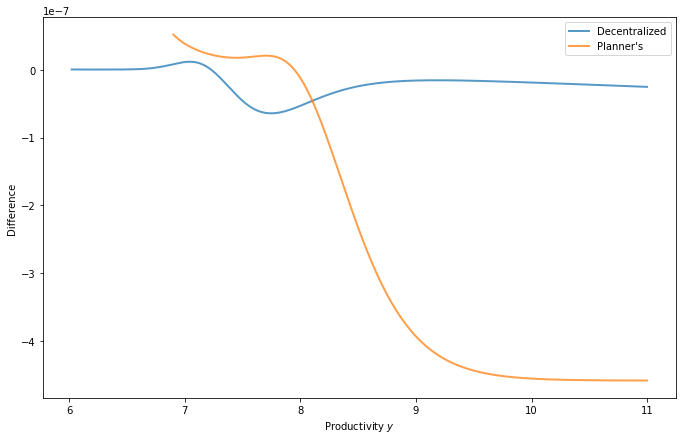

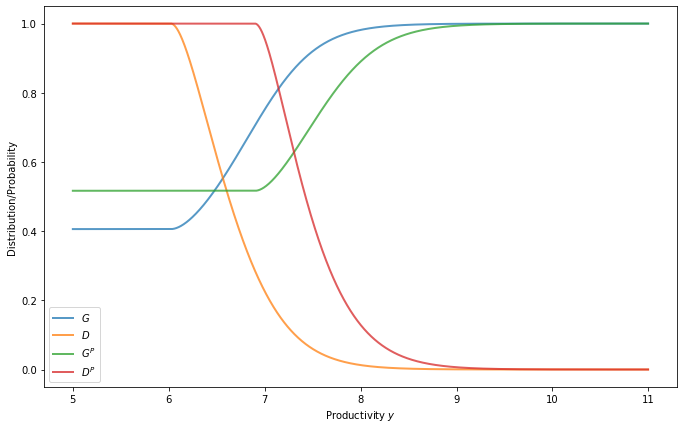

In [89]:
# Run Planner's Problem with decentralized as initial guess
tol = 1e-8
max_iter = 5e4
# max_iter = 1e5
# max_iter = 20
slow = 1e-1
# slow = 3e-1
ps = 1e4
# ps = 5e3
# ps = 1
verbose = True

guess_p = v_grid, n_grid, np.zeros(y_grid_size)

v_grid_p, n_grid_p, lam_grid_p = lsoj_solve_model_p(
    lsoj, guess_p, tol=tol, max_iter=max_iter, slow=slow, verbose=verbose, print_skip=ps)

lsoj_list_facts(lsoj, v_grid_p, n_grid_p)
lsoj_graph_results_p(lsoj, v_grid, n_grid, v_grid_p, n_grid_p, lam_grid_p)

In [75]:
lsoj_iterate, lsoj_make_grids, _, _, lsoj_make_grids_p, C, c, c_inv, q, ell, q_p, ell_p = lsoj_operator_factory(lsoj)

theta, G_grid, D_grid, vac_ext, pos_ext = lsoj_make_grids_p(v_grid_p, n_grid_p, lam_grid_p)

guess_p = v_grid_p, n_grid_p, lam_grid_p

theta, lam_grid_p, vac_ext, pos_ext

(0.02958865067952969,
 array([-104.64270819, -104.21828662, -103.79386505, ...,  978.50640503,
         979.11728422,  979.72816342]),
 array([-24.82774289, -24.82774289, -24.82774289, ..., -52.22029156,
        -52.22029454, -52.22029749]),
 array([-1.0748124 , -1.0748124 , -1.0748124 , ..., -1.5211971 ,
        -1.52119713, -1.52119717]))

In [31]:
lsoj_iterate, lsoj_make_grids, _, lsoj_make_grids_p, C, c, c_inv, q, ell, q_p, ell_p = lsoj_operator_factory(lsoj)

theta, G_grid, D_grid, vac_ext, pos_ext = lsoj_make_grids_p(v_grid_p, n_grid_p, lam_grid_p)

print(theta)

size = 25
alpha_grid = np.linspace(.1,.9, size)

q_grid = np.empty(size)
q_p_grid = np.empty(size)
ell_grid = np.empty(size)
ell_p_grid = np.empty(size)

for i, a in enumerate(alpha_grid):
    
    lsoj_t = LSOnJob(B, b, delta, xi, eta, phi, a, y_min, y_max, y_grid_size, gamma, c_grid)
    
    _, _, _, _, C, c, c_inv, q, ell, q_p, ell_p = lsoj_operator_factory(lsoj_t)
    
    q_grid[i], q_p_grid[i] = q(theta), q_p(theta)
    ell_grid[i], ell_p_grid[i] = ell(theta), ell_p(theta)

0.0187870190314276


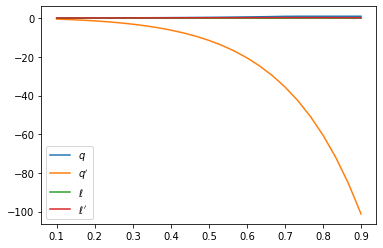

In [33]:
fig, ax = plt.subplots()
ax.plot(alpha_grid, q_grid, label=r"$q$")
ax.plot(alpha_grid, q_p_grid, label=r"$q'$")
ax.plot(alpha_grid, ell_grid, label=r"$\ell$")
ax.plot(alpha_grid, ell_p_grid, label=r"$\ell'$")
ax.legend()

plt.show()

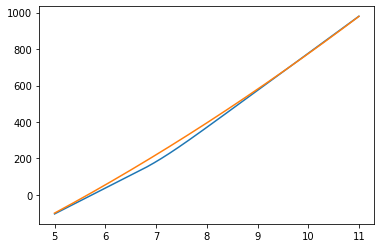

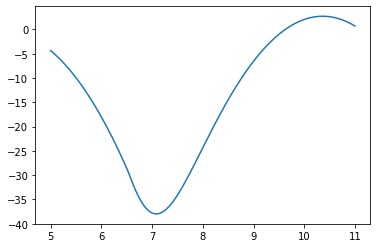

In [54]:
a = 5
b = 100
c = -725

plt.plot(y_grid, lam_grid_p)
plt.plot(y_grid, a * y_grid**2 + b * y_grid + c)
plt.show()

plt.plot(y_grid, lam_grid_p - (a * y_grid**2 + b * y_grid + c))
plt.show()

alpha is 0.5000
Error at iter 0 is 0.0000
theta is 0.029588650700465395 [-104.6427082  -104.21828662 -103.79386505 ...  978.50640502  979.11728421
  979.72816341] [-24.82774286 -24.82774286 -24.82774286 ... -52.22029166 -52.22029464
 -52.22029759] [-1.0748124  -1.0748124  -1.0748124  ... -1.5211971  -1.52119713
 -1.52119717]
Converged in 1 iterations
Theta is 0.0296; firms find worker with probability 0.3434


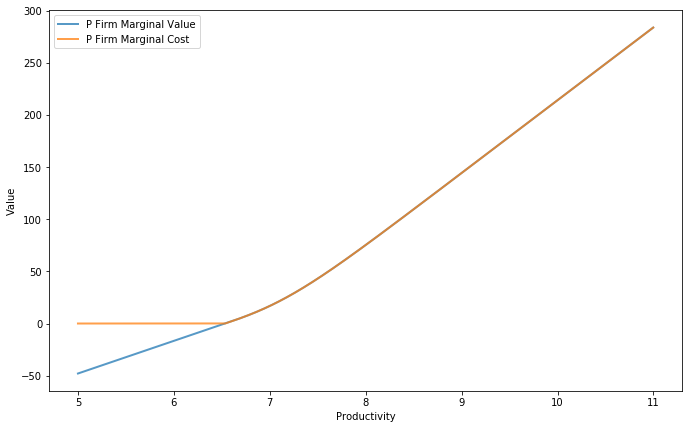

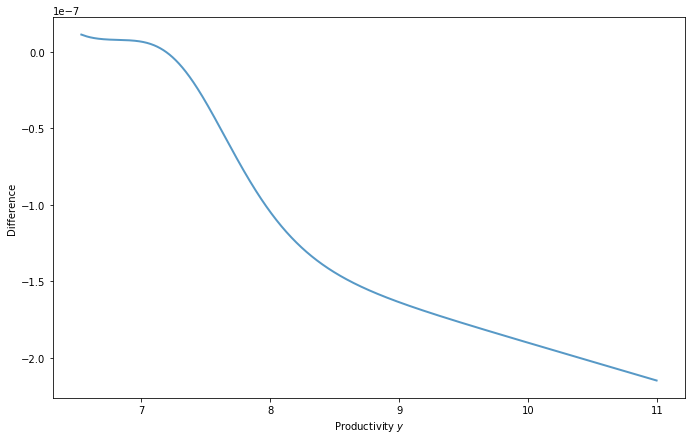

alpha is 0.5244
Error at iter 0 is 0.0050
theta is 0.02859224486250954 [-119.37980039 -118.96670956 -118.55361873 ...  944.42181536  945.03269429
  945.64357322] [-26.31499126 -26.31499126 -26.31499126 ... -52.97808378 -52.97808697
 -52.97809014] [-1.05876075 -1.05876075 -1.05876075 ... -1.4896747  -1.48967474
 -1.48967478]
Error at iter 10000 is 0.0000
theta is 0.023088069866911465 [-113.05961128 -112.63108047 -112.20254967 ...  965.77410187  966.38498106
  966.99586025] [-34.34913119 -34.34913119 -34.34913119 ... -69.32708122 -69.3270866
 -69.32709192] [-1.12669558 -1.12669558 -1.12669558 ... -1.58378746 -1.58378751
 -1.58378756]
Error at iter 20000 is 0.0000
theta is 0.02309076505679448 [-113.06019365 -112.63166998 -112.20314631 ...  965.77256282  966.38344201
  966.9943212 ] [-34.34191313 -34.34191313 -34.34191313 ... -69.33242394 -69.33242934
 -69.33243469] [-1.12671276 -1.12671276 -1.12671276 ... -1.58379499 -1.58379504
 -1.58379509]
Converged in 23461 iterations
Theta is 0.0231;

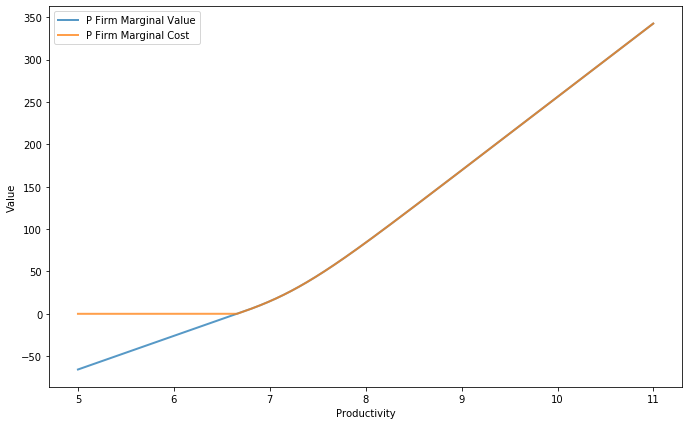

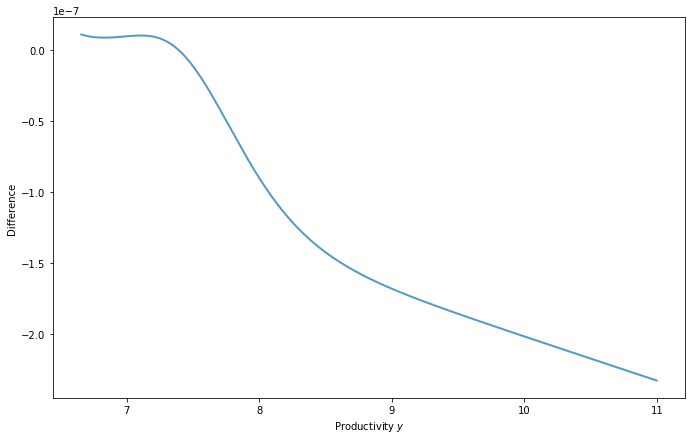

alpha is 0.5489
Error at iter 0 is 0.0041
theta is 0.022329187190867805 [-129.40518433 -128.98865818 -128.57213203 ...  928.18679504  928.79767379
  929.40855256] [-36.26411425 -36.26411425 -36.26411425 ... -70.28347254 -70.28347834
 -70.28348409] [-1.10934501 -1.10934501 -1.10934501 ... -1.55034523 -1.55034529
 -1.55034534]
Error at iter 10000 is 0.0000
theta is 0.01756908572331319 [-122.43097378 -121.99848795 -121.56600212 ...  951.48640005  952.09727923
  952.70815842] [-48.76269838 -48.76269838 -48.76269838 ... -94.75252921 -94.75253968
 -94.75255004] [-1.18452113 -1.18452113 -1.18452113 ... -1.65402391 -1.65402398
 -1.65402406]
Error at iter 20000 is 0.0000
theta is 0.017571468499653874 [-122.43140228 -121.99892422 -121.56644615 ...  951.4846512   952.09553038
  952.70640956] [-48.75137071 -48.75137071 -48.75137071 ... -94.75764125 -94.75765178
 -94.7576622 ] [-1.18453927 -1.18453927 -1.18453927 ... -1.65403246 -1.65403253
 -1.65403261]
Converged in 23621 iterations
Theta is 0.017

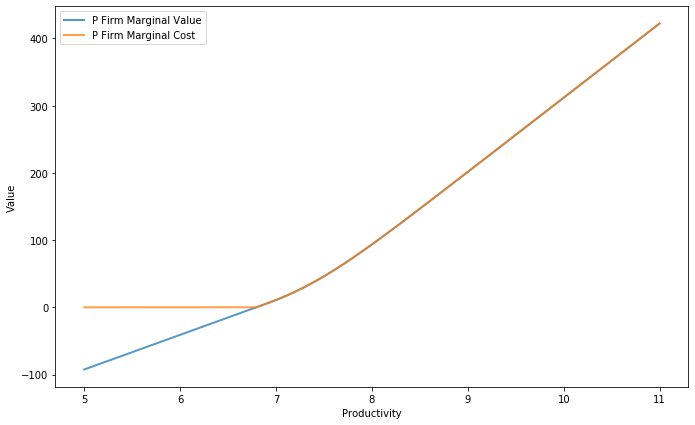

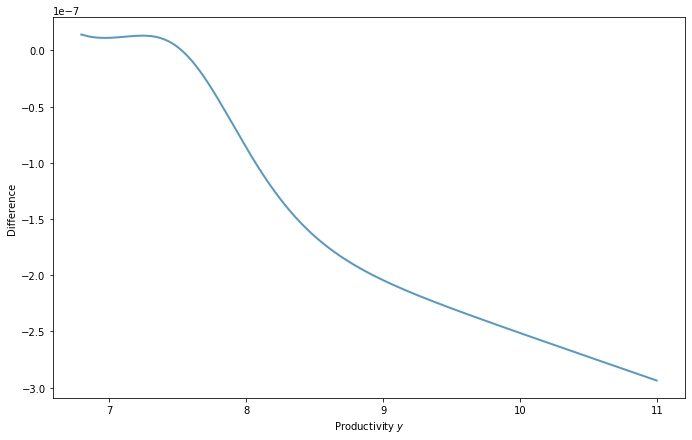

alpha is 0.5733
Error at iter 0 is 0.0033
theta is 0.017004120014504364 [-140.66002473 -140.24027534 -139.82052595 ...  909.79463756  910.40551599
  911.01639444] [-51.2802533  -51.2802533  -51.2802533  ... -95.94091185 -95.94092318
 -95.9409344 ] [-1.16525923 -1.16525923 -1.16525923 ... -1.61782133 -1.61782142
 -1.61782151]
Error at iter 10000 is 0.0000
theta is 0.012979552436793999 [-132.91843595 -132.48213695 -132.04583795 ...  935.3863808   935.99725996
  936.60813914] [ -71.39273951  -71.39273951  -71.39273951 ... -133.92486893 -133.92489109
 -133.92491303] [-1.24927551 -1.24927551 -1.24927551 ... -1.73316943 -1.73316955
 -1.73316967]
Error at iter 20000 is 0.0000
theta is 0.012981598664048917 [-132.91867551 -132.48238494 -132.04609438 ...  935.38440119  935.99528035
  936.60615953] [ -71.37431986  -71.37431986  -71.37431986 ... -133.92844458 -133.92846686
 -133.92848892] [-1.24929473 -1.24929473 -1.24929473 ... -1.73317911 -1.73317923
 -1.73317935]
Converged in 23772 iterations
T

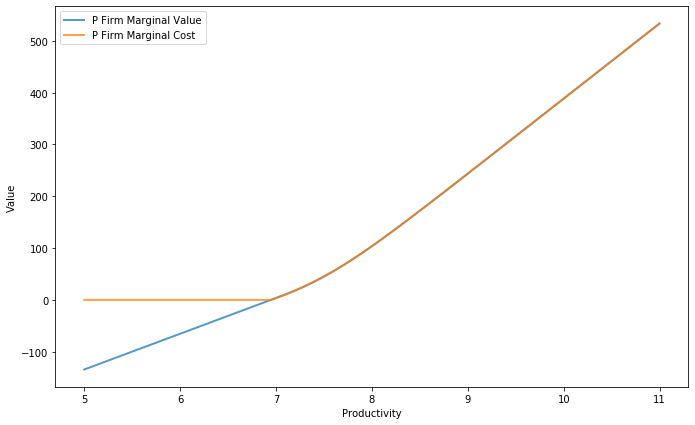

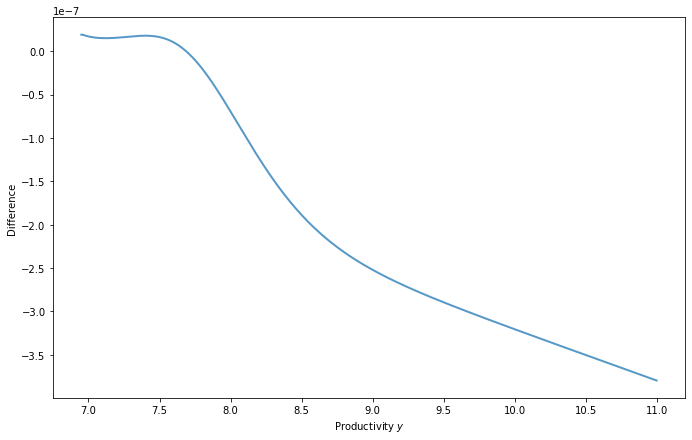

alpha is 0.5978
Error at iter 0 is 0.0026
theta is 0.012571567261077622 [-153.37344183 -152.95068773 -152.52793363 ...  888.84015919  889.45103698
  890.06191479] [ -74.76344988  -74.76344988  -74.76344988 ... -135.36645864 -135.36648268
 -135.36650648] [-1.22731161 -1.22731161 -1.22731161 ... -1.69311281 -1.69311296
 -1.6931131 ]
Error at iter 10000 is 0.0001
theta is 0.00928221422146294 [-144.62463545 -144.18478601 -143.74493657 ...  917.13042753  917.74130667
  918.35218584] [-108.62505987 -108.62500985 -108.6249539  ... -195.96152188 -195.96157133
 -195.96162029] [-1.3218148  -1.3218148  -1.3218148  ... -1.82291225 -1.82291246
 -1.82291267]
Error at iter 20000 is 0.0000
theta is 0.009260904213211685 [-144.72282806 -144.28286389 -143.84289971 ...  917.15019181  917.76107095
  918.37195012] [-108.40883596 -108.40883581 -108.40883565 ... -196.8649267  -196.86497868
 -196.86503016] [-1.32222563 -1.32222563 -1.32222563 ... -1.82281595 -1.82281616
 -1.82281637]
Converged in 29443 iterati

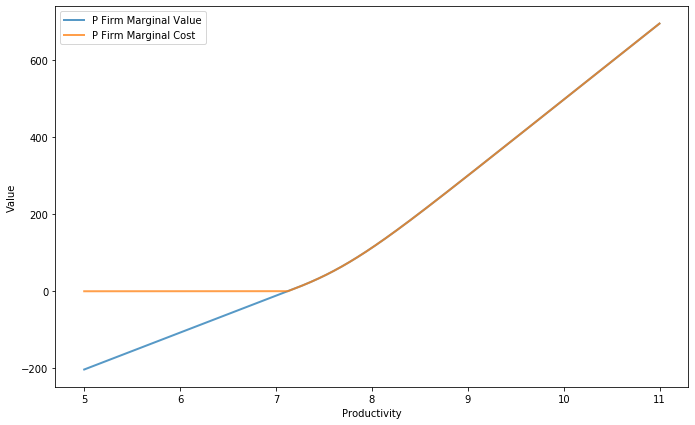

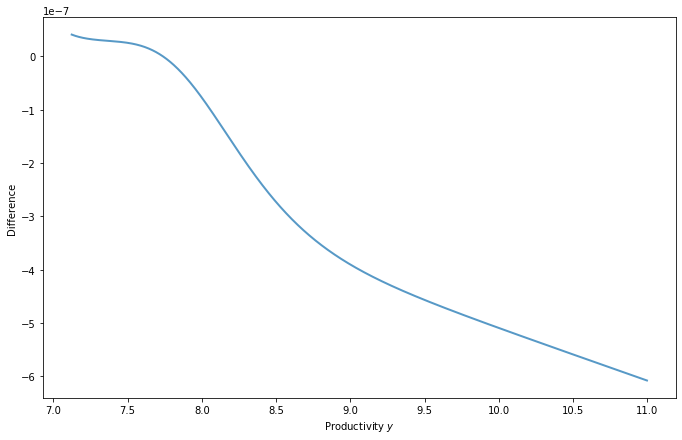

alpha is 0.6222
Error at iter 0 is 0.8569
theta is 2.6197397907510007 [ -10.12831397   -9.7027864    -9.27725882 ... 1100.42921353 1101.04010611
 1101.65099858] [ -0.23045144  -0.23045144  -0.23045144 ... -11.09376099 -11.09376499
 -11.09376894] [-11.35310337 -11.35310337 -11.35310337 ... -14.49531276 -14.49531278
 -14.4953128 ]
Error at iter 10000 is 0.3101
theta is 0.07088265536524573 [ 181.10885165  181.69565566  182.29724691 ... 2048.67514751 2049.28603235
 2049.89691713] [ -31.12182711  -31.13071713  -31.13977574 ... -317.55992247 -317.55995361
 -317.55998443] [-14.43881251 -14.43881251 -14.43881251 ... -18.62082707 -18.62082708
 -18.6208271 ]
Error at iter 20000 is 0.1981
theta is 0.12818059073859328 [ -49.50976888  -49.33740332  -49.16416132 ... 1010.46100994 1011.07188907
 1011.68276821] [ -7.2001461   -7.19777096  -7.19532501 ... -37.42181858 -37.42182843
 -37.42183818] [-2.08692588 -2.08692588 -2.08692588 ... -2.76940495 -2.76940496
 -2.76940497]
Error at iter 30000 is 0.0040

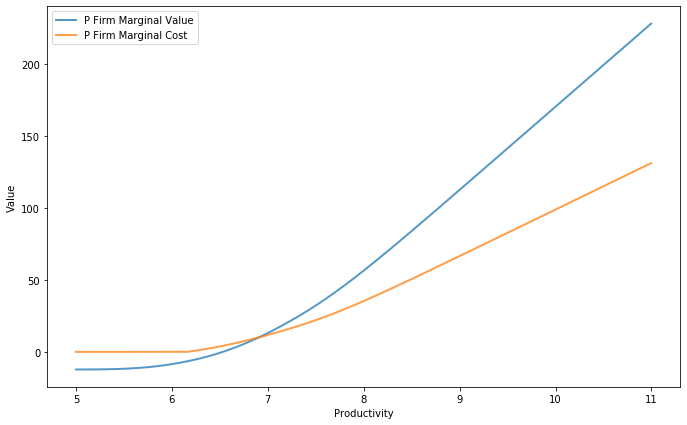

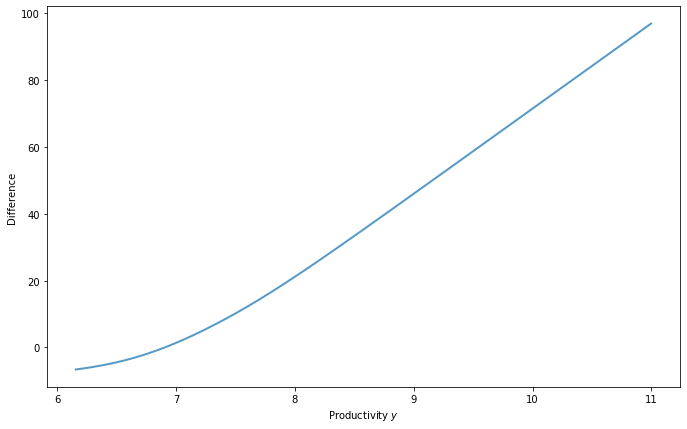

alpha is 0.6467


KeyboardInterrupt: 

In [80]:
import math
height = 7
width = height * 1.62
    
alpha_bar = 0.72

guess_p_2 = copy.copy(guess_p)

alpha_grid = np.linspace(.5, alpha_bar, 10)

for a in alpha_grid:
    print(f"alpha is {a:.4f}")
    lsoj_temp = copy.copy(lsoj)
    lsoj_temp.alpha = a
    
    _, _, _, lsoj_make_grids_p, _, c, _, q, _, _, _ = lsoj_operator_factory(lsoj_temp)
    
    v_grid_p, n_grid_p, lam_grid_p = lsoj_solve_model_p(
        lsoj_temp, guess_p_2, tol=tol, max_iter=max_iter, slow=slow, verbose=verbose, print_skip=ps)
    
    guess_p_2 = v_grid_p, n_grid_p, lam_grid_p
    
    theta_p, G_grid_p, D_grid_p, vac_ext, pos_ext = lsoj_make_grids_p(v_grid_p, n_grid_p, lam_grid_p)
        
    print(f"Theta is {theta_p:.4f}; firms find worker with probability {q(theta_p):.4f}")
    J_p = B * lam_grid_p * G_grid_p * q(theta_p) + vac_ext
    mc_p = c(v_grid_p)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_p, lw=2, alpha=0.75, label="P Firm Marginal Value")
    ax.plot(y_grid, mc_p, lw=2, alpha=0.75, label="P Firm Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    plt.show()
        
    # Plot the differences from the above curves
    J_p_diff = J_p - mc_p
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid_p > 0], J_p_diff[v_grid_p > 0], lw=2, alpha=0.75, label="Planner's")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")

    plt.show()
    
    if math.isnan(v_grid_p[0]):
        print(f"Broke down when alpha is {a:.4f}")
        break
        
        
v_grid, n_grid = lsoj_solve_model(lsoj_temp, guess, tol=tol, max_iter=max_iter, slow=slow, verbose=verbose, print_skip=ps)
        
lsoj_list_facts(lsoj_temp, v_grid_p, n_grid_p)
lsoj_graph_results_p(lsoj_temp, v_grid, n_grid, v_grid_p, n_grid_p, lam_grid_p)

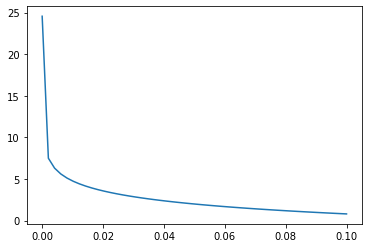

In [48]:
theta_grid = np.linspace(1e-7, 1e-1, 50)

q_p_grid = np.empty(50)

for i, t in enumerate(theta_grid):
    q_p_grid[i] = np.log(alpha * phi * t**(-alpha - 1))
    
plt.plot(theta_grid, q_p_grid)
plt.show()

Error at iter 0 is 2.8069
Error at iter 10000 is 0.0001
Converged in 15312 iterations
TOC: Elapsed: 0:00:2.67
Unemployment is 12.53. According to LoM, should be 12.53
Workers match with probability 2.73. Firms/Outsourcers match with probability 36.62
Total vacancies searching for workers are 0.0093. Theta is 0.0746
Checking if vacancies + LoM imply right positions:
 Firms largest error = 0.002546 at position 555 

Hiring entry from code 0.0280; theory 0.0280


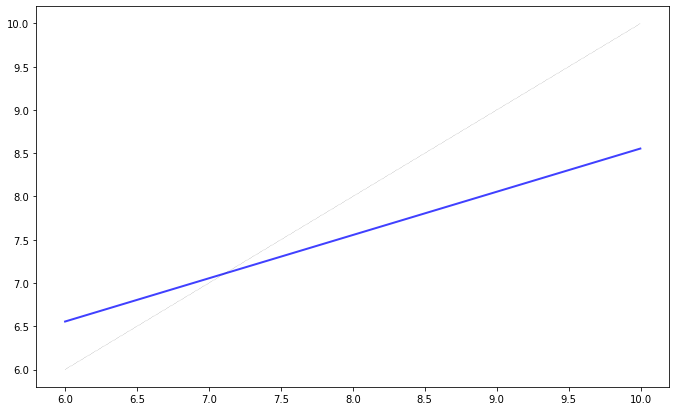

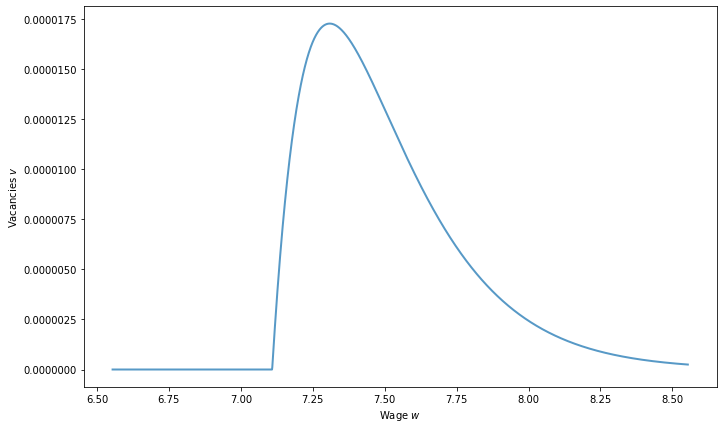

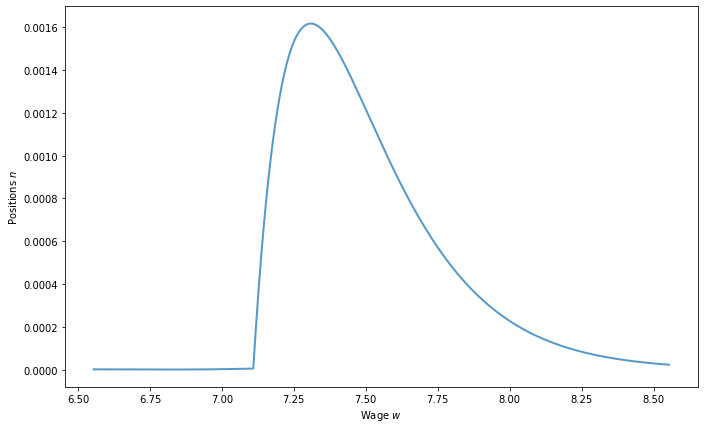

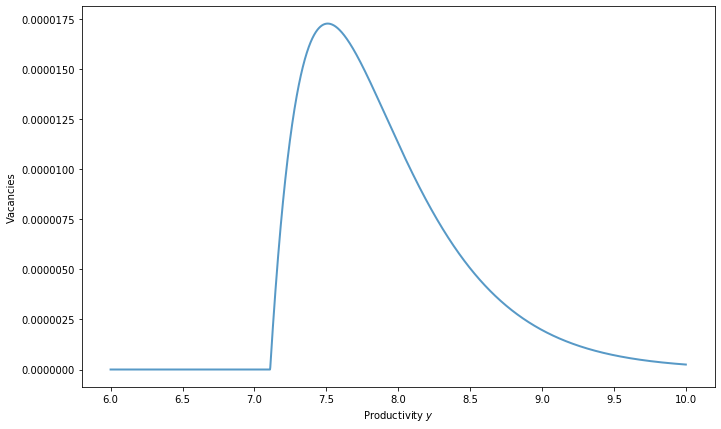

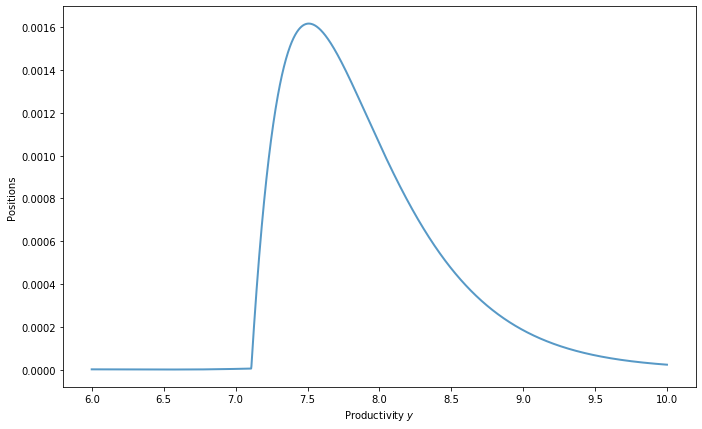

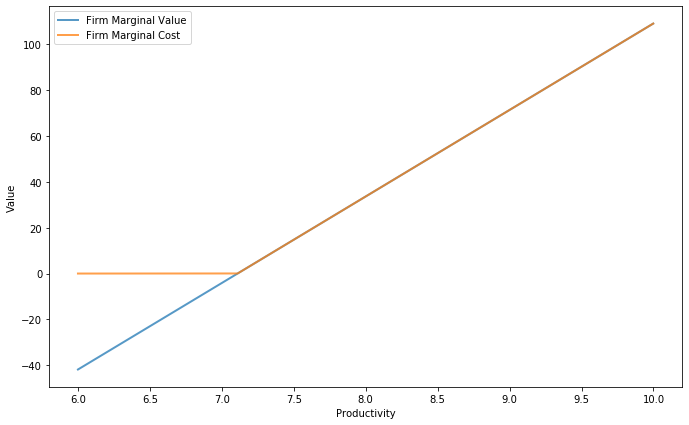

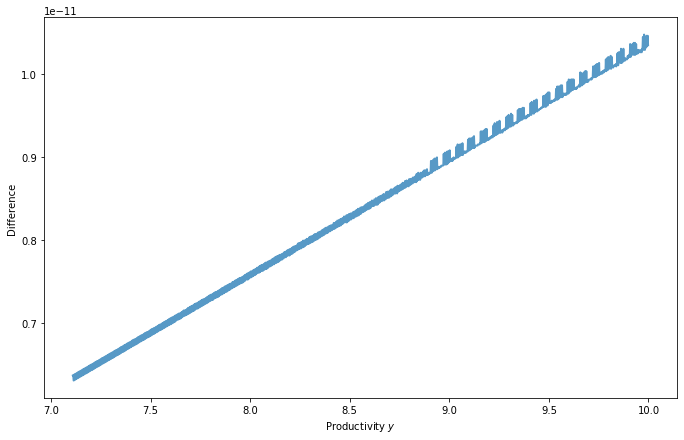

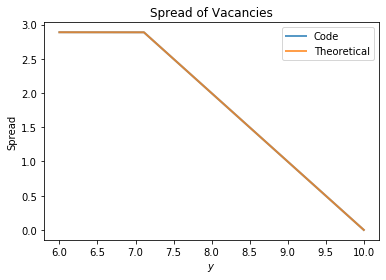

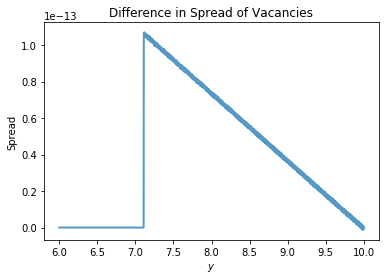

In [16]:
# These blocks run on code from LS (see below). Give same eqbm when xi = 0
ls = LSModel(B, b, delta, eta, phi, alpha, y_min, y_max, y_grid_size, gamma, c_grid)

# Record initial guesses
v_grid = np.ones(y_grid_size) / y_grid_size * 0.1
n_grid = np.ones(y_grid_size) / y_grid_size * 0.1

guess = v_grid, n_grid

qe.tic()
v_grid_2, n_grid_2 = ls_solve_model(
    ls, guess, tol, max_iter, slow, planner=False, verbose=verbose, print_skip=ps)
qe.toc()    
    
ls_list_facts(ls, v_grid_2, n_grid_2)

ls_graph_results(ls, v_grid_2, n_grid_2)

Error at iter 0 is 0.0086
Error at iter 10000 is 0.0001
Converged in 14717 iterations
TOC: Elapsed: 0:00:2.47
Unemployment is 20.86. According to LoM, should be 20.86
Workers match with probability 1.48. Firms/Outsourcers match with probability 67.39
Total vacancies searching for workers are 0.0046. Theta is 0.0220
Checking if vacancies + LoM imply right positions:
 Firms largest error = 0.002546 at position 754 

Hiring entry from code 0.0172; theory 0.0172


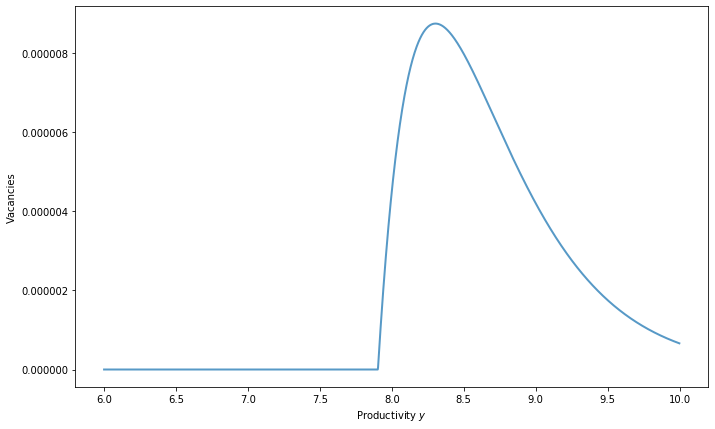

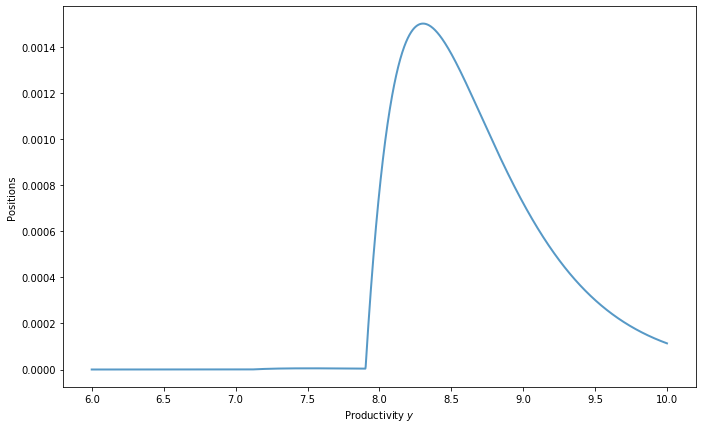

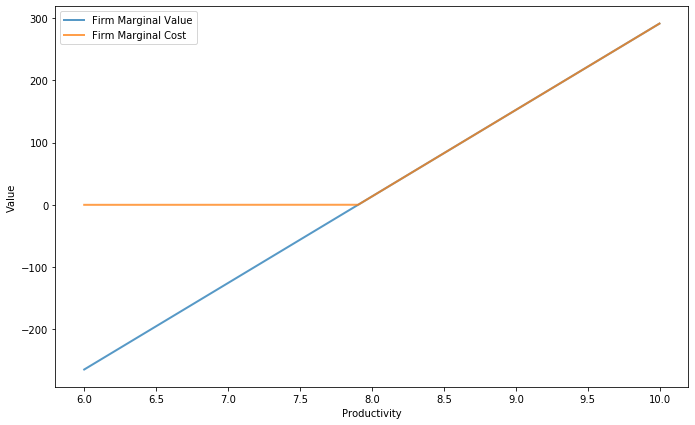

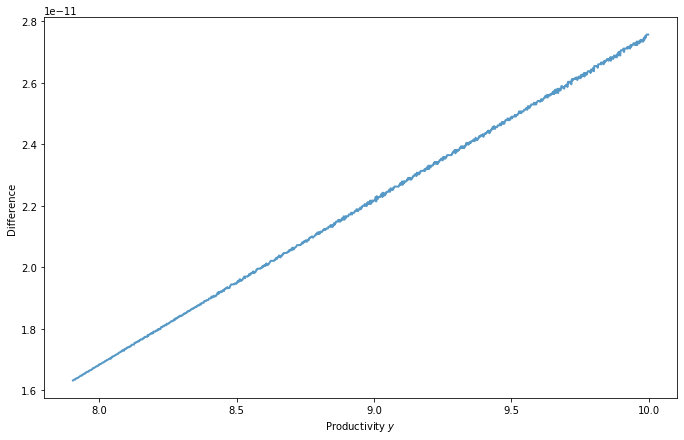

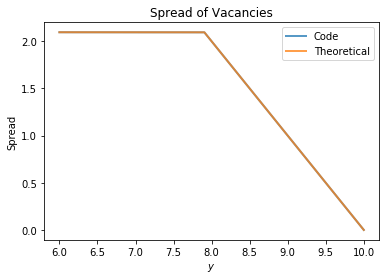

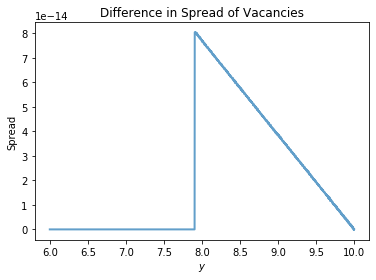

In [17]:
# Take guess from previous
tol = 1e-5
max_iter = 1e5
# max_iter = 50
slow = 1e-1
print_skip = 1e4
verbose = True

guess = v_grid_2, n_grid_2

qe.tic()
v_grid_p_2, n_grid_p_2 = ls_solve_model(
    ls, guess, tol, max_iter, slow, planner=True, verbose=verbose, print_skip=ps)
qe.toc()    
    
ls_p_list_facts(ls, v_grid_p_2, n_grid_p_2)

ls_p_graph_results(ls, v_grid_p_2, n_grid_p_2)

In [1]:
# Code stolen from LS. Should be same as model when xi = 0
# Create a verison of the model without ousourcers (or on the job search) following L+S pg 953
# Solves both the decentralized and planner's problems

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
import copy
from numba import njit, jitclass, int64, float64
from interpolation import interp
from IPython.core.debugger import set_trace
from scipy.optimize import minimize

class LSModel:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate 
    eta is workers bargaining power
    phi is effectiveness of matching function
    alpha is elasticity of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    gamma is steepness of marginal cost, 
    c_grid is level of entry cost
    tau_grid is optional grid of taxes/transfers per vacancy
    """
    def __init__(self, B, b, delta, eta, phi, alpha, y_min, y_max, y_grid_size, gamma, c_grid, tau_grid=0):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.c_grid = B, b, delta, eta, gamma, c_grid
        self.r = 1 / B - 1
        self.tau_grid = tau_grid
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size, self.y_min, self.y_max = y_grid_size, y_min, y_max    
        self.rm = (y_max - y_min) / y_grid_size
        
        self.phi, self.alpha = phi, alpha
        
# Set up neccesary functions
def ls_operator_factory(ls):
    
    r, b, delta, eta, gamma, c_grid = ls.r, ls.b, ls.delta, ls.eta, ls.gamma, ls.c_grid
    phi, alpha = ls.phi, ls.alpha
    tau_grid = ls.tau_grid
    
    y_grid, y_grid_size, rm, y_max = ls.y_grid, ls.y_grid_size, ls.rm, ls.y_max    
    
    @njit()
    def q(theta):
        return min(phi * theta**(-alpha), 1)
    
    @njit()
    def ell(theta):
        return min(phi * theta**(1 - alpha), 1)
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    # tau is potential taxes
    @njit()
    def C(v_grid, tau_grid=0):
        return c_grid * v_grid**gamma - v_grid * tau_grid
    
    @njit()
    def c(v_grid, tau_grid=0):
        return c_grid * gamma * v_grid**(gamma - 1) - tau_grid

    @njit()
    def c_inv(cost_grid, tau_grid=0):
        return (np.maximum(cost_grid + tau_grid, 0) / (gamma * c_grid))**(1 / (gamma - 1))
    
    # Given v_grid, and n_grid find the distribution of workers
    # Including market tightness theta and distribution of vacancies f_grid
    @njit()
    def worker_dist(v_grid, n_grid):
        
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        
        # Calculate theta 
        theta = v / u
        
        # f is pdf of vacancies 
        f_grid = v_grid / v
        
        return theta, f_grid
    
    # Solve decentralized problem
    # Given v_grid, and n_grid find
    # Market tightness theta and Wages w
    @njit()
    def make_grids(v_grid, n_grid):    
        
        # Get distribution of workers
        theta, f_grid = worker_dist(v_grid, n_grid)
        
        # What is the value of search for unemployed?
        f_tot = np.sum(c(v_grid, tau_grid) * f_grid * rm)
        Gamma_U = ell(theta) / q(theta) * eta / (1 - eta) * f_tot
        
        # Find wage
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U)
        
        return theta, w_grid
    
    # Given v_grid and n_grid find new values
    @njit()
    def iterate(v_grid, n_grid):
        
        theta, w_grid = make_grids(v_grid, n_grid)
        
        # Value of firm
        J_hire = q(theta) * (y_grid - w_grid) / (r + delta)
        
        # Update vacancies
        v_grid_new = c_inv(J_hire, tau_grid)
        
        # Update positions
        n_grid_new = (1 - delta) * n_grid + q(theta) * v_grid_new
                       
        return v_grid_new, n_grid_new
    
    # Solve Planner's problem
    # Given v_grid and n_grid find
    # Market tightness theta
    # Planner's value of worker search Gamma_P
    # The lagrange multiplier lamda_grid
    @njit()
    def p_make_grids(v_grid, n_grid):    
        
        # Get distribution of workers
        theta, f_grid = worker_dist(v_grid, n_grid)
        
        # What is the value of search for unemployed?
        f_tot = np.sum(c(v_grid) * f_grid * rm)
        Gamma_P = ell(theta) / q(theta) * alpha / (1 - alpha) * f_tot
        
        # Find lagrange multiplier lamda_grid
        lambda_grid = (y_grid - b - Gamma_P) / (r + delta)
        
        return theta, Gamma_P, lambda_grid
    
    # Given v_grid and n_grid find new values
    @njit()
    def p_iterate(v_grid, n_grid):
        
        # Get theta, Gamma_P, and lambda_grid
        theta, Gamma_P, lambda_grid = p_make_grids(v_grid, n_grid)
        
        # Value of firms
        J_hire = lambda_grid * q(theta) - Gamma_P / theta
        
        # Update vacancies
        v_grid_new = c_inv(J_hire)
        
        # Update positions
        n_grid_new = (1 - delta) * n_grid + q(theta) * v_grid_new
                       
        return v_grid_new, n_grid_new
    
    return iterate, make_grids, p_iterate, p_make_grids, C, c, c_inv, q, ell 

# Solve model, both decentralized and Planner 
def ls_solve_model(ls, guess, tol, max_iter, slow, planner=False, verbose=False, print_skip=1e4):
    
    if planner == False:
        iterate, _, _, _, _, _, _, _, _ = ls_operator_factory(ls)
    else:
        _, _, iterate, _, _, _, _, _, _ = ls_operator_factory(ls)
    
    v_grid, n_grid = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1    

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new = iterate(v_grid, n_grid)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err = max(err_v, err_n)

        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
        
        i += 1
    
    if i < max_iter:
        print(f'Converged in {i} iterations')
    if i == max_iter:
        print(f'Failed to Converge.')

    return v_grid_new, n_grid_new

# Planner can use taxes/transfers to implement optimal policy. Give these taxes
def ls_taxes(ls, v_grid_p, n_grid_p):
    
    iterate, make_grids, p_iterate, p_make_grids, C, c, c_inv, q, ell = ls_operator_factory(ls)
    
    r, delta, alpha, eta = ls.r, ls.delta, ls.alpha, ls.eta
    y_grid = ls.y_grid
    rm = ls.rm
    
    theta, Gamma_P, lambda_grid = p_make_grids(v_grid_p, n_grid_p)
    
    # Taxes are a function of parameters plus the firms cost of entry compared to the average cost of entry
    c_av = np.sum(c(v_grid_p) * v_grid_p * rm) / np.sum(v_grid_p * rm)
    tau_grid = (eta * c(v_grid_p) 
           + (1 - eta) * ((eta - alpha) * theta * q(theta) - alpha * (r + delta + eta * theta * q(theta)))
          / (1 - alpha) / (r + delta + eta * theta * q(theta)) * c_av)
    
    # Total taxes can be found two ways. Do they agree?
    tau_tot = np.sum(tau_grid * v_grid_p * rm)
    
    tau_tot_2 = (
        (eta - alpha) * (r + delta + theta * q(theta)) * np.sum(c(v_grid_p) * v_grid_p * rm)
        / ((1 - alpha) * (r + delta + eta * theta * q(theta)))
    ) 
    
    print(f"Total taxes are {tau_tot:.8f} or {tau_tot_2:.8f}")
    
    # Create an ls_tau with tau_grid
    ls_tau = copy.copy(ls)
    ls_tau.tau_grid = tau_grid 
    
    return tau_grid, ls_tau
    
# Graph decentralized results
def ls_graph_results(ls, v_grid, n_grid,
                  save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\LS'):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from ls
    iterate, make_grids, p_iterate, p_make_grids, C, c, c_inv, q, ell = ls_operator_factory(ls)
    
    theta, w_grid = make_grids(v_grid, n_grid)
    
    r, delta = ls.r, ls.delta
    c_grid = ls.c_grid
    rm = ls.rm
    y_grid, y_grid_size = ls.y_grid, ls.y_grid_size
    tau_grid = ls.tau_grid
        
    # Graph wages by productivity    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, lw=2, alpha=0.75, c='b')
    ax.plot(y_grid, y_grid, lw=.5, alpha=0.5, c='k', ls=":")
    
    if save:
        fig.savefig(folder + file + 'LS Wages v Productivity.pdf')
    else:
        plt.show()   

    # Graph vacacies by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, rm * v_grid, lw=2, alpha=0.75, label="Firms")
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
    
    if save:
        fig.savefig(folder + file + 'LS Vacancies v Wages.pdf')
    else:
        plt.show()         
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, rm * n_grid, lw=2, alpha=0.75, label="Firms")
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    
    if save:
        fig.savefig(folder + file + 'LS Positions v Wages.pdf')
    else:
        plt.show() 
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, rm * v_grid, lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
    
    if save:
        fig.savefig(folder + file + 'LS Firm Vacancies.pdf')
    else:
        plt.show()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, rm * n_grid, lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
    
    if save:
        fig.savefig(folder + file + 'LS Firm Positions.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    J_hire = q(theta) * (y_grid - w_grid) / (r + delta)
    mc = c(v_grid, tau_grid)   
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, lw=2, alpha=0.75, label="Firm Marginal Value")
    ax.plot(y_grid, mc, lw=2, alpha=0.75, label="Firm Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'LS M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid > 0], J_hire_diff[v_grid > 0], lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    
    if save:
        fig.savefig(folder + file + 'LS M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot the actual vs theoretical spread of vacancies
    spread_theory = (c(v_grid, tau_grid)[-1] - c(v_grid, tau_grid)) * (r + delta) / ((1 - eta) * q(theta))
    
    spread_prod = y_grid[-1] - y_grid
    spread_prod[v_grid == 0] = spread_theory[v_grid == 0]
    
    dif = spread_prod - spread_theory
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod, lw=2, alpha=0.75, label='Code')
    ax.plot(y_grid, spread_theory, lw=2, alpha=0.75, label='Theoretical')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    
    if save:
        fig.savefig(folder + file + 'LS Spread.pdf')
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid, dif, lw=2, alpha=0.75)
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file + 'LS Spread Dif')
    else:
        plt.show() 
        
# Create a function to print some facts that are useful for decentralized
def ls_list_facts(ls, v_grid, n_grid):
    
    iterate, make_grids, p_iterate, p_make_grids, C, c, c_inv, q, ell = ls_operator_factory(ls)
    
    theta, w_grid = make_grids(v_grid, n_grid)
    
    r, delta = ls.r, ls.delta
    gamma, c_grid, eta = ls.gamma, ls.c_grid, ls.eta
    rm = ls.rm
    y_grid = ls.y_grid
    tau_grid = ls.tau_grid
    
    u = 1 - np.sum(n_grid * rm)
    u_lom = delta / (delta + ell(theta))
    v = np.sum(v_grid * rm)
    
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {v:.4f}. Theta is {theta:.4f}")
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss = v_grid * q(theta) / delta
    err = max(np.abs(n_ss - n_grid))
    err_at = np.argmax(np.abs(n_ss - n_grid))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Firms largest error = {err:.6f} at position {err_at} \n"
    )  
    
    # Check if entry is consitent with theory
    firm_sum = np.sum(c(v_grid, tau_grid) * v_grid * rm)
    
    entry_code = np.sum(v_grid * (y_grid - b) * rm)
    
    entry_theory = (r + delta + eta * theta * q(theta)) / ((1 - eta) * q(theta)) * firm_sum
    
    print(f'Hiring entry from code {entry_code:.4f}; theory {entry_theory:.4f}')
    
# Graph Planner results
def ls_p_graph_results(ls, v_grid, n_grid,
                  save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\Outsourcers Basic'):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from ls
    iterate, make_grids, p_iterate, p_make_grids, C, c, c_inv, q, ell = ls_operator_factory(ls)
    
    theta, Gamma_P, lambda_grid = p_make_grids(v_grid, n_grid)
    
    r, delta = ls.r, ls.delta
    c_grid = ls.c_grid
    rm = ls.rm
    y_grid, y_grid_size = ls.y_grid, ls.y_grid_size
         
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, rm * v_grid, lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
    
    if save:
        fig.savefig(folder + file + 'LS Planner Firm Vacancies.pdf')
    else:
        plt.show()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, rm * n_grid, lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
    
    if save:
        fig.savefig(folder + file + 'LS Planner Firm Positions.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = lambda_grid * q(theta) - Gamma_P / theta    
    mc = c(v_grid)   
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, lw=2, alpha=0.75, label="Firm Marginal Value")
    ax.plot(y_grid, mc, lw=2, alpha=0.75, label="Firm Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'LS Planner M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid > 0],
            J_hire_diff[v_grid > 0], lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    
    if save:
        fig.savefig(folder + file + 'LS Planner M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot the actual vs theoretical spread of vacancies
    spread_theory = (c(v_grid)[-1] - c(v_grid)) * (r + delta) / q(theta)
    
    spread_prod = y_grid[-1] - y_grid
    spread_prod[v_grid == 0] = spread_theory[v_grid == 0]
    
    dif = spread_prod - spread_theory
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod, lw=2, alpha=0.75, label='Code')
    ax.plot(y_grid, spread_theory, lw=2, alpha=0.75, label='Theoretical')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    
    if save:
        fig.savefig(folder + file + 'LS Planner Spread.pdf')
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid, dif, lw=2, alpha=0.7)
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file + 'LS Planner Spread Dif')
    else:
        plt.show() 
        
# Create a function to print some facts that are useful for Planner's
def ls_p_list_facts(ls, v_grid, n_grid):
    
    # Get data needed from ls
    iterate, make_grids, p_iterate, p_make_grids, C, c, c_inv, q, ell = ls_operator_factory(ls)
    
    theta, Gamma_P, lambda_grid = p_make_grids(v_grid, n_grid)
    
    r, delta = ls.r, ls.delta
    gamma, c_grid, eta, alpha = ls.gamma, ls.c_grid, ls.eta, ls.alpha
    rm = ls.rm
    y_grid = ls.y_grid
    
    u = 1 - np.sum(n_grid * rm)
    u_lom = delta / (delta + ell(theta))
    v = np.sum(v_grid * rm)
    
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {v:.4f}. Theta is {theta:.4f}")
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss = v_grid * q(theta) / delta
    err = max(np.abs(n_ss - n_grid))
    err_at = np.argmax(np.abs(n_ss - n_grid))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Firms largest error = {err:.6f} at position {err_at} \n"
    )  
    
    # Check if entry is consitent with theory
    firm_sum = np.sum(c(v_grid) * v_grid * rm)
    
    entry_code = np.sum(v_grid * (y_grid - b) * rm)
    
    entry_theory = (r + delta + alpha * theta * q(theta)) / ((1 - alpha) * q(theta)) * firm_sum
    
    print(f'Hiring entry from code {entry_code:.4f}; theory {entry_theory:.4f}')
    
# Look at tax problem and compare to Planner's
def tax_compare(ls, v_grid_p, n_grid_p, v_grid_tau, n_grid_tau,
                save=False, height=7, 
                folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                file=r'\LS Comp'):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from ls
    iterate, make_grids, p_iterate, p_make_grids, C, c, c_inv, q, ell = ls_operator_factory(ls)
    
    theta, Gamma_P, lambda_grid = p_make_grids(v_grid, n_grid)
    
    rm = ls.rm
    y_grid = ls.y_grid
    tau_grid = ls.tau_grid
    
    # Sum total taxes/transfers to firms
    tau_tot = np.sum(tau_grid * v_grid_tau * rm)
    print(f"Total taxes/transfers are {tau_tot:.4f}")
    
    # Graph taxes by productiivty
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, ls.tau_grid, lw=2, alpha=0.75)
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer")
    
    if save:
        fig.savefig(folder + file + 'LS Taxes.pdf')
    else:
        plt.show()
    
    # Graph difference in firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, rm * (v_grid_p - v_grid_tau), lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    
    if save:
        fig.savefig(folder + file + 'LS Taxes v Planner Vacancies.pdf')
    else:
        plt.show()
        
    # Graph difference in firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, rm * (n_grid_p - n_grid_tau), lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    
    if save:
        fig.savefig(folder + file + 'LS Taxes v Planner Positions.pdf')
    else:
        plt.show()   